This notebook generates more accurate predictions compared to the a-priori notebook but I worked on this during and after the 2020 Australian Open so they aren't true predictions, unlike the ones found in the a-priori notebook.

The overall workflow is similar to the a-priori notebook but I've added some extra features and used a more robust validation strategy. The data is from the R Deuce package but has been augmented with player elo, so please run the ex-post-elo notebook first to calculate player elo before running this notebook (or remove player elo as a feature).

There are some global parameters in the cell below which you can tinker around with to see how performance changes.


In [1]:
#When the model starts training and making predictions
year_start = 2000 

#Maximum amount of matches to be aggregated in rolling window
window_length = 21 

#Tournaments we want to aggregate for, and train our model on. Can also try ['Australian Open', 'US Open', 'Us Open']
tourney_names = ['Australian Open'] 

In [2]:
import numpy as np
import pandas as pd
import os
import eli5
from eli5.sklearn import PermutationImportance
import re
import datetime
import itertools
from sklearn.metrics import log_loss

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

Using TensorFlow backend.


In [5]:
def data_cleaning(df, 
                  tourneys_to_include = ['Grand Slams', 'Masters', '250 or 500', 'Tour Finals', 'Davis Cup'], 
                  start_year=2000 ):
    
    #Renaming columns
    new_cols = [
    'Unnamed: 0', 'tourney_id', 'tourney_name', 'surface', 'draw_size',
       'tourney_level', 'match_num', 'winner_id', 'winner_seed',
       'winner_entry', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc',
       'winner_age', 'winner_rank', 'winner_rank_points', 'loser_id',
       'loser_seed', 'loser_entry', 'loser_name', 'loser_hand', 'loser_ht',
       'loser_ioc', 'loser_age', 'loser_rank', 'loser_rank_points', 'score',
       'best_of', 'round', 'minutes', 'winner_ace', 'winner_df', 'winner_svpt', 'winner_1stIn',
       'winner_1stWon', 'winner_2ndWon', 'winner_SvGms', 'winner_bpSaved', 'winner_bpFaced', 'loser_ace',
       'loser_df', 'loser_svpt', 'loser_1stIn', 'loser_1stWon', 'loser_2ndWon', 'loser_SvGms',
       'loser_bpSaved', 'loser_bpFaced', 'W1', 'W2', 'W3', 'W4', 'W5', 'L1', 'L2',
       'L3', 'L4', 'L5', 'retirement', 'WTB1', 'LTB1', 'WTB2', 'LTB2', 'WTB3',
       'LTB3', 'WTB4', 'LTB4', 'WTB5', 'LTB5', 'tourney_start_date', 'year',
       'match_id', 'winner_old_elo', 'loser_old_elo'
    ]
    
    df.columns = new_cols
    
    #You can change what matches to include. I've chosen to exclude Futures matches and the Challenger tour
    # tourney_levels = 'Grand Slams', '250 or 500', 'Davis Cup', 'Masters', 'Challenger', 'Tour Finals', 'Futures'
    df = df[(df['tourney_level'].isin(tourneys_to_include)) &\
            (df['year'] >= start_year) & (df['surface'] == 'Hard')&\
            (~df['round'].isin(['Q1', 'Q2', 'Q3', 'Q4']))
           ]

    #Converting dates to datetime
    df.loc[:,'tourney_start_date'] = pd.to_datetime(df['tourney_start_date'])
    df.loc[:,'year'] = pd.to_datetime(df['year'])
    
    #Factorizing round
    df.loc[:,'round'] = pd.factorize(df['round'])[0]
    
    #Parsing scores
    scores = df.loc[:,'score'].str.split(' ')
    scores = scores.fillna(0)     
    loser_total_games = []
    winner_total_games = []
    
    for index, value in scores.items():
        loser_game_score = 0
        winner_game_score = 0
        try:
            if value == 0 or value == ['W/O']:            
                loser_total_games.append(loser_game_score)
                winner_total_games.append(winner_game_score)

            else:
                loser_game_score = 0
                winner_game_score = 0

                for set_ in value:                
                    try:
                        text = re.match(r"(\d)\-(\d)",set_ )
                        loser_game_score += int(text.group(2))
                        winner_game_score += int(text.group(1))
                    except:
                        pass
                loser_total_games.append(loser_game_score)
                winner_total_games.append(winner_game_score)
        except:
            print(index, value)

    df.loc[:,'winner_total_games'] = winner_total_games
    df.loc[:,'loser_total_games'] = loser_total_games
    df.loc[:,'total_games'] = df['winner_total_games'] + df['loser_total_games']
    df.loc[:,'loser_RtGms'] = df['winner_SvGms']
    df.loc[:,'winner_RtGms'] = df['loser_SvGms']
    df.loc[:,'loser_bp'] = df['winner_bpFaced']
    df.loc[:,'winner_bp'] = df['loser_bpFaced']


    df.loc[:,'loser_bpWon'] = df['winner_bpFaced'] - df['winner_bpSaved'] 
    df.loc[:,'winner_bpWon'] = df['loser_bpFaced'] - df['loser_bpSaved'] 
    
    #Imputing returns data so we can construct features
    df.loc[:,'winner_2ndIn'] = df['winner_svpt'] - df['winner_1stIn'] - df['winner_df']
    df.loc[:,'loser_2ndIn'] = df['loser_svpt'] - df['loser_1stIn'] - df['loser_df']
    df.loc[:,'loser_rtpt'] = df['winner_svpt']
    df.loc[:,'winner_rtpt'] = df['loser_svpt']
    df.loc[:,'winner_rtptWon'] = df['loser_svpt'] -  df['loser_1stWon'] - df['loser_2ndWon']
    df.loc[:,'loser_rtptWon'] = df['winner_svpt'] -  df['winner_1stWon'] - df['winner_2ndWon']
    df.loc[:,'winner_svptWon'] = df['winner_1stWon'] + df['winner_2ndWon']
    df.loc[:,'loser_svptWon'] = df['loser_1stWon'] + df['loser_2ndWon']
    df.loc[:,'winner_total_points'] = df['winner_svptWon'] + df['winner_rtptWon']
    df.loc[:,'loser_total_points'] = df['loser_svptWon'] + df['loser_rtptWon']
    df.loc[:,'total_points'] = df['winner_total_points'] + df['loser_total_points']
    
    #Dropping columns
    cols_to_drop =[
        'draw_size',
        'winner_seed',
        'winner_entry',
        'loser_seed',
        'loser_entry',
        'score',
        'W1', 'W2', 'W3', 'W4', 'W5', 'L1', 'L2',
        'L3', 'L4', 'L5', 'WTB1', 'LTB1', 'WTB2', 'LTB2', 'WTB3',
        'LTB3', 'WTB4', 'LTB4', 'WTB5', 'LTB5'
        ]
    
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    #Filling nans values
    df.loc[:,'loser_rank'] = df['loser_rank'].fillna(500)
    df.loc[:,'winner_rank'] = df['winner_rank'].fillna(500)
    df = df.fillna(df.mean())
    
    return(df)

def convert_long(df):
    
    #Separating features into winner and loser so we can create rolling averages for each major tournament
    winner_cols = [col for col in df.columns if col.startswith('w')]
    loser_cols = [col for col in df.columns if col.startswith('l')]
    common_cols = [
        'tourney_id', 'tourney_name', 'surface', 'tourney_level',
       'match_num','best_of', 'round',
       'minutes','retirement', 'tourney_start_date', 'year', 'match_id',
        'total_points', 'total_games'
    ]
    
    #Will also add opponent's rank
    df_winner = df[winner_cols + common_cols + ['loser_rank']]
    df_loser = df[loser_cols + common_cols + ['winner_rank']]
    
    df_winner['won'] = 1
    df_loser['won'] = 0
    
    #Renaming columns
    df_winner.columns = [col.replace('winner','player').replace('loser', 'opponent') for col in df_winner.columns]
    df_loser.columns = df_winner.columns
    
    df_long = df_winner.append(df_loser, ignore_index=True)
    
    return(df_long)

def get_new_features(df):
    
    #Creating new features we can play around with, note that not all features may be used
    df.loc[:,'player_serve_win_ratio'] = (df['player_1stWon'] + df['player_2ndWon'])/\
    (df['player_1stIn'] + df['player_2ndIn'] + df['player_df'] )
    
    df.loc[:,'player_return_win_ratio'] = df['player_rtptWon']/df['player_rtpt']
    
    df.loc[:,'player_bp_per_game'] = df['player_bp']/df['player_RtGms']
    
    df.loc[:,'player_bp_conversion_ratio'] = df['player_bpWon']/df['player_bp']
    
    #Setting nans to zero for breakpoint conversion ratio
    df.loc[:,'player_bp_conversion_ratio'].fillna(0, inplace=True)
    
    df.loc[:,'player_game_win_ratio'] = df['player_total_games']/df['total_games']
    
    df.loc[:,'player_point_win_ratio'] = df['player_total_points']/df['total_points']
    
    #df['player_set_Win_Ratio'] = df['Player_Sets_Won']/df['Total_Sets']
    
    df.loc[:,'player_clutch_factor'] = df['player_game_win_ratio'] - df['player_point_win_ratio']
    
    df.loc[:,'player_log_rank'] = np.log(df['player_rank'])
    
    df.loc[:,'player_log_rank_points'] = np.log(df['player_rank_points'])
    
    df.loc[:,'player_win_weight'] = df['won'] * np.exp(-df['opponent_rank']/100)

    #Let's try weighting some of the features by the opponent's rank
    
    #df['Player_Set_Win_Ratio_Weighted'] = df['Player_Set_Win_Ratio']*np.exp((df['Player_Rank']-df['Opponent_Rank'])/500)
    df.loc[:,'player_game_win_ratio_weighted'] = df['player_game_win_ratio']*np.exp((df['player_rank']-df['opponent_rank'])/500)
    df.loc[:,'player_point_win_ratio_weighted'] = df['player_point_win_ratio']*np.exp((df['player_rank']-df['opponent_rank'])/500)
    
    return(df)

def get_rolling_features(df, date_df, rolling_cols, last_cols, window):
    
    #This code is basically copied straight from Qile Tan's notebook
    
    df = df.sort_values(['player_name', 'tourney_name', 'tourney_start_date'], ascending=True)
    
    for index, tournament_date in enumerate(date_df.tourney_start_date):
        print(index, tournament_date)
        
        #Subsetting to tournaments at most 1 year before tournament date to reduce computation time
        df_temp = df.loc[(df['tourney_start_date']< tournament_date) & (df['tourney_start_date'] > tournament_date - datetime.timedelta(days=365))]

        #Only taking the most recent value for the feature, if specified in last_cols
        if last_cols != None:
            df_temp_last = df_temp.groupby('player_name')[last_cols].last().reset_index()

        #Taking a rolling average of the x (window_length) most recent matches before specified tournament date,
        #for features specified in rolling_cols
        df_temp = df_temp.groupby('player_name')[rolling_cols].rolling(window,1).mean().reset_index()

        #Only taking the most recent rolling average
        df_temp = df_temp.groupby('player_name').tail(1)

        df_temp = df_temp.merge(df_temp_last, on = 'player_name', how='left')

        #Adding a column telling us what tournament the rolling average is for
        if index == 0:
            df_result = df_temp
            df_result['tournament_date_index'] = tournament_date

        else:
            df_temp['tournament_date_index'] = tournament_date
            df_result = df_result.append(df_temp)
        
    
    df_result.drop('level_1', axis=1, inplace=True)
    
    return(df_result)

def merge_data(df, df_rolling_atp):
    
    df_atp = df.copy()
    #Subsetting match data to Grand Slams and Masters
    df_atp = df_atp.loc[df_atp['tourney_level'].isin(['Grand Slams', 'Masters'])]

    #Removing unnecessary columns from match data
    cols_to_keep = ['winner_name','loser_name','tourney_name','tourney_start_date', 'tourney_level', 'round']

    df_atp = df_atp[cols_to_keep]
    df1 = df_atp.copy()
    df1.columns = ['player_1','player_2','tourney_name','tourney_start_date', 'tourney_level', 'round']
    df1['player_1_win'] = 1

    df2 = df_atp.copy()
    df2.columns = ['player_2','player_1','tourney_name','tourney_start_date', 'tourney_level', 'round']
    df2['player_1_win'] = 0

    df_atp = pd.concat([df1, df2], sort=False)
    df_atp.reset_index(drop=True, inplace=True)
    

    #Joining rolling features for p1 with match data
    df_atp = df_atp.merge(df_rolling_atp, how='left',
                         left_on = ['player_1', 'tourney_start_date'],
                         right_on = ['player_name', 'tournament_date_index'],
                         validate = 'm:1')


    df_atp = df_atp.merge(df_rolling_atp, how='left',
                         left_on = ['player_2', 'tourney_start_date'],
                         right_on = ['player_name', 'tournament_date_index'],
                         validate = 'm:1',
                         suffixes=('_p1', '_p2'))
    
    return(df_atp)

def get_player_difference(df, diff_cols = None):
    
    p1_cols = [i + '_p1' for i in diff_cols] # column names for player 1 stats
    p2_cols = [i + '_p2' for i in diff_cols] # column names for player 2 stats


    # Filling missing values
    df['player_rank_p1'] = df['player_rank_p1'].fillna(500)
    df['player_log_rank_p1'] = df['player_log_rank_p1'].fillna(np.log(500))
    df[p1_cols] = df[p1_cols].fillna(-1)
    
    df['player_rank_p2'] = df['player_rank_p2'].fillna(500)
    df['player_log_rank_p2'] = df['player_log_rank_p2'].fillna(np.log(500))
    df[p2_cols] = df[p2_cols].fillna(-1)

    
    new_column_name = [i + '_diff' for i in diff_cols]

    # Take the difference
    df_p1 = df[p1_cols]
    df_p2 = df[p2_cols]
    
    df_p1.columns=new_column_name
    df_p2.columns=new_column_name
    
    df_diff = df_p1 - df_p2
    df_diff.columns = new_column_name
    
    #Dropping spare columns
    df.drop(p1_cols + p2_cols, axis=1, inplace=True)
    
    # Concat the df_diff and raw_df
    df = pd.concat([df, df_diff], axis=1)
    
    return(df)

def f_chain_val_scores(df, model, ML_cols, tournaments):
    years = df.tourney_start_date.dt.year.unique()

    train_years = []
    for index, year in enumerate(years):
        if index == 0:
            train_temp = [year]
            train_years.append(train_temp)
        else:
            train_temp = train_years[index-1]
            train_years.append(train_temp + [year])


    train_years.pop(-1)

    val_years = list(years)
    val_years.pop(0)
    
    scores = []
    for train_index, val_index in zip(train_years, val_years):
        train_temp = deuce_atp_final.loc[(df.tourney_start_date.dt.year.isin(train_index)) &\
                                         (df.tourney_level.isin(['Grand Slams'])) &\
                                         (df.tourney_name.isin(tournaments)),:]
        val_temp = deuce_atp_final.loc[df.tourney_start_date.dt.year.isin([val_index]) &\
                                         (df.tourney_level.isin(['Grand Slams'])) &\
                                         (df.tourney_name.isin(tournaments)),:]

        X_train = train_temp[ML_cols].drop('player_1_win', axis =1)
        y_train = train_temp['player_1_win']
        X_val = val_temp[ML_cols].drop('player_1_win', axis =1)
        y_val = val_temp['player_1_win']

        eval_set = [(X_val, y_val)]
        model.fit(X_train,
                  y_train,
                 eval_set = eval_set,
                 eval_metric="logloss",
                 early_stopping_rounds = 20,
                 verbose=100000) 
        score = min(model.evals_result()['validation_0']['logloss'])
        scores.append(score)
    
    return(scores)

def f_chain_val_test_scores(df, model, ML_cols, tournaments):
    years = df.tourney_start_date.dt.year.unique()

    train_years = []
    for index, year in enumerate(years):
        if index == 0:
            train_temp = [year]
            train_years.append(train_temp)
        else:
            train_temp = train_years[index-1]
            train_years.append(train_temp + [year])


    train_years.pop(-1)
    train_years.pop(-1)

    val_years = list(years)
    val_years.pop(0)
    val_years.pop(-1)
    
    test_years = list(years)
    test_years.pop(0)
    test_years.pop(0)
    
    val_scores = []
    test_scores = []
    
    for train_index, val_index, test_index in zip(train_years, val_years, test_years):
        train_temp = deuce_atp_final.loc[(df.tourney_start_date.dt.year.isin(train_index)) &\
                                         (df.tourney_level.isin(['Grand Slams'])) &\
                                         (df.tourney_name.isin(tournaments)),:]
        val_temp = deuce_atp_final.loc[df.tourney_start_date.dt.year.isin([val_index]) &\
                                         (df.tourney_level.isin(['Grand Slams'])) &\
                                         (df.tourney_name.isin(tournaments)),:]
        test_temp = deuce_atp_final.loc[df.tourney_start_date.dt.year.isin([test_index]) &\
                                         (df.tourney_level.isin(['Grand Slams'])) &\
                                         (df.tourney_name.isin(tournaments)),:]

        X_train = train_temp[ML_cols].drop('player_1_win', axis =1)
        y_train = train_temp['player_1_win']
        X_val = val_temp[ML_cols].drop('player_1_win', axis =1)
        y_val = val_temp['player_1_win']
        X_test = test_temp[ML_cols].drop('player_1_win', axis =1)
        y_test = test_temp['player_1_win']

        eval_set = [(X_val, y_val)]
        model.fit(
            X_train,
            y_train,
            eval_set = eval_set,
            eval_metric="logloss",
            early_stopping_rounds=20,
            verbose=100000) 
        
        val_score = min(model.evals_result()['validation_0']['logloss'])
        val_scores.append(val_score)
        
        test_preds = model.predict_proba(X_test)
        test_score = log_loss(y_test, test_preds)
        test_scores.append(test_score)
    
    return(val_scores, test_scores, model, X_val, y_val)

## Cleaning data and converting to long form for feature engineering

In [6]:
deuce_atp = pd.read_csv('Data/atp_matches_elo.csv')
deuce_atp = data_cleaning(deuce_atp, ['Grand Slams', '250 or 500', 'Davis Cup', 'Masters', 'Challenger', 'Tour Finals'])
deuce_atp_long = convert_long(deuce_atp)

/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [7]:
deuce_atp

,Unnamed: 0,tourney_id,tourney_name,surface,tourney_level,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,best_of,round,minutes,winner_ace,winner_df,winner_svpt,winner_1stIn,winner_1stWon,winner_2ndWon,winner_SvGms,winner_bpSaved,winner_bpFaced,loser_ace,loser_df,loser_svpt,loser_1stIn,loser_1stWon,loser_2ndWon,loser_SvGms,loser_bpSaved,loser_bpFaced,retirement,tourney_start_date,year,match_id,winner_old_elo,loser_old_elo,winner_total_games,loser_total_games,total_games,loser_RtGms,winner_RtGms,loser_bp,winner_bp,loser_bpWon,winner_bpWon,winner_2ndIn,loser_2ndIn,loser_rtpt,winner_rtpt,winner_rtptWon,loser_rtptWon,winner_svptWon,loser_svptWon,winner_total_points,loser_total_points,total_points
261832,261833,2000-339,Adelaide,Hard,250 or 500,1,102358,Thomas Enqvist,R,190.000000,SWE,25.810000,4.0,1850.0,103096,Arnaud Clement,R,173.000000,FRA,22.050000,56.0,490.0,3,0,76.0,6.0,0.0,66.0,29.0,23.0,23.0,10.0,2.0,2.0,1.0,3.0,59.0,37.0,25.0,13.0,9.0,2.0,4.0,False,2000-01-03,1970-01-01 00:00:00.000002000,2000-339:1,2250.746185,2040.946132,12,7,19,10.0,9.0,2.0,4.0,0.0,2.0,37.0,19.0,66.0,59.0,21.0,20.0,46.0,38.0,67.0,58.0,125.0
261833,261834,2000-339,Adelaide,Hard,250 or 500,2,103819,Roger Federer,R,185.000000,SUI,18.400000,64.0,515.0,102533,Jens Knippschild,R,190.000000,GER,24.880000,91.0,404.0,3,0,45.0,6.0,3.0,46.0,28.0,24.0,12.0,9.0,0.0,0.0,3.0,5.0,42.0,15.0,13.0,12.0,8.0,0.0,3.0,False,2000-01-03,1970-01-01 00:00:00.000002000,2000-339:2,2136.358749,2008.365766,12,5,17,9.0,8.0,0.0,3.0,0.0,3.0,15.0,22.0,46.0,42.0,17.0,10.0,36.0,25.0,53.0,35.0,88.0
261834,261835,2000-339,Adelaide,Hard,250 or 500,3,102998,Jan Michael Gambill,R,190.000000,USA,22.580000,58.0,544.0,101885,Wayne Arthurs,L,190.000000,AUS,28.800000,105.0,243.0,3,0,115.0,8.0,3.0,81.0,40.0,35.0,28.0,15.0,0.0,1.0,26.0,2.0,103.0,59.0,49.0,22.0,16.0,4.0,5.0,False,2000-01-03,1970-01-01 00:00:00.000002000,2000-339:3,2122.214415,1967.916718,16,16,32,15.0,16.0,1.0,5.0,1.0,1.0,38.0,42.0,81.0,103.0,32.0,18.0,63.0,71.0,95.0,89.0,184.0
261835,261836,2000-339,Adelaide,Hard,250 or 500,4,103206,Sebastien Grosjean,R,175.000000,FRA,21.600000,27.0,928.0,102776,Andrew Ilie,R,180.000000,AUS,23.710000,54.0,602.0,3,0,65.0,4.0,2.0,66.0,35.0,28.0,14.0,7.0,4.0,4.0,0.0,3.0,49.0,22.0,12.0,8.0,8.0,1.0,6.0,False,2000-01-03,1970-01-01 00:00:00.000002000,2000-339:4,2134.843751,2000.279069,12,3,15,7.0,8.0,4.0,6.0,0.0,5.0,29.0,24.0,66.0,49.0,29.0,24.0,42.0,20.0,71.0,44.0,115.0
261836,261837,2000-339,Adelaide,Hard,250 or 500,5,102796,Magnus Norman,R,188.000000,SWE,23.590000,15.0,1244.0,102401,Scott Draper,L,178.000000,AUS,25.580000,154.0,219.0,3,0,68.0,6.0,2.0,52.0,32.0,26.0,12.0,10.0,0.0,1.0,4.0,2.0,73.0,40.0,25.0,16.0,10.0,7.0,10.0,False,2000-01-03,1970-01-01 00:00:00.000002000,2000-339:5,2229.547202,2025.585606,12,8,20,10.0,10.0,1.0,10.0,1.0,3.0,18.0,31.0,52.0,73.0,32.0,14.0,38.0,41.0,70.0,55.0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776367,776368,2019-M-DC-2019-FLS-M-GBR-ESP-01,Davis Cup Finals SF: GBR vs ESP,Hard,Davis Cup,2,104745,Rafael Nadal,L,185.000000,ESP,33.459274,1.0,9985.0,105554,Daniel Evans,R,175.000000,GBR,29.489391,42.0,1124.0,3,7,85.0,9.0,0.0,46.0,29.0,24.0,11.0,8.0,0.0,0.0,4.0,2.0,59.0,43.0,24.0,5.0,8.0,5.0,9.0,False,2019-11-23,1970-01-01 00:00:00.000002019,2019-M-DC-2019-FLS-M-GBR-ESP-01:2,2731.873670,2264.304656,12,4,16,8.0,8.0,0.0,9.0,0.0,4.0,17.0,14.0,46.0,59.0,30.0,11.0,35.0,29.0,65.0,40.0,105.0
776368,776369,2019-M-DC-2019-FLS-M-RUS-CAN-01,Davis Cup Finals SF: RUS vs CAN,Hard,Davis Cup,1,126094,Andrey Rublev,R,185.337849,RUS,22.078029,23.0,1584.0,105577,Vasek Pospisil,R,193.000000,CAN,29.404517,150.0,3

In [8]:
deuce_atp.columns

Index(['Unnamed: 0', 'tourney_id', 'tourney_name', 'surface', 'tourney_level',
       'match_num', 'winner_id', 'winner_name', 'winner_hand', 'winner_ht',
       'winner_ioc', 'winner_age', 'winner_rank', 'winner_rank_points',
       'loser_id', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc',
       'loser_age', 'loser_rank', 'loser_rank_points', 'best_of', 'round',
       'minutes', 'winner_ace', 'winner_df', 'winner_svpt', 'winner_1stIn',
       'winner_1stWon', 'winner_2ndWon', 'winner_SvGms', 'winner_bpSaved',
       'winner_bpFaced', 'loser_ace', 'loser_df', 'loser_svpt', 'loser_1stIn',
       'loser_1stWon', 'loser_2ndWon', 'loser_SvGms', 'loser_bpSaved',
       'loser_bpFaced', 'retirement', 'tourney_start_date', 'year', 'match_id',
       'winner_old_elo', 'loser_old_elo', 'winner_total_games',
       'loser_total_games', 'total_games', 'loser_RtGms', 'winner_RtGms',
       'loser_bp', 'winner_bp', 'loser_bpWon', 'winner_bpWon', 'winner_2ndIn',
       'loser_2ndIn', 'loser

## Engineering new features and calculating rolling average

In [9]:
deuce_atp_long = get_new_features(deuce_atp_long)

In [10]:
deuce_atp_long.columns

Index(['player_id', 'player_name', 'player_hand', 'player_ht', 'player_ioc',
       'player_age', 'player_rank', 'player_rank_points', 'player_ace',
       'player_df', 'player_svpt', 'player_1stIn', 'player_1stWon',
       'player_2ndWon', 'player_SvGms', 'player_bpSaved', 'player_bpFaced',
       'player_old_elo', 'player_total_games', 'player_RtGms', 'player_bp',
       'player_bpWon', 'player_2ndIn', 'player_rtpt', 'player_rtptWon',
       'player_svptWon', 'player_total_points', 'tourney_id', 'tourney_name',
       'surface', 'tourney_level', 'match_num', 'best_of', 'round', 'minutes',
       'retirement', 'tourney_start_date', 'year', 'match_id', 'total_points',
       'total_games', 'opponent_rank', 'won', 'player_serve_win_ratio',
       'player_return_win_ratio', 'player_bp_per_game',
       'player_bp_conversion_ratio', 'player_game_win_ratio',
       'player_point_win_ratio', 'player_clutch_factor', 'player_log_rank',
       'player_log_rank_points', 'player_win_weight',
   

In [11]:
# These are the tournaments we want to get the rolling average of features for, they will then be used for training
roll_dates = deuce_atp.loc[deuce_atp['tourney_level'].isin(['Grand Slams']) &\
                          deuce_atp['tourney_name'].isin(tourney_names)].groupby(['tourney_name', 'tourney_start_date'])\
.size().reset_index()[['tourney_name', 'tourney_start_date']]

# We also want to aggregate matches just before the 2020 AO
roll_dates.loc[-1] = ['Australian Open', pd.to_datetime('2020-01-20')]

last_cols = ['player_rank', 'player_log_rank', 'player_rank_points', 'player_log_rank_points', 'player_ht', 'player_old_elo']
rolling_cols = [
    'player_serve_win_ratio', 'player_return_win_ratio',
    'player_bp_per_game', 'player_bp_conversion_ratio',
    'player_game_win_ratio', 'player_point_win_ratio',
    'player_clutch_factor', 'player_win_weight',
    'player_game_win_ratio_weighted', 'player_point_win_ratio_weighted'
]

rolling_features = get_rolling_features(deuce_atp_long, roll_dates, rolling_cols, last_cols, 21  )

0 2000-01-17 00:00:00
1 2001-01-15 00:00:00
2 2002-01-14 00:00:00
3 2003-01-13 00:00:00
4 2004-01-19 00:00:00
5 2005-01-17 00:00:00
6 2006-01-16 00:00:00
7 2007-01-15 00:00:00
8 2008-01-14 00:00:00
9 2009-01-19 00:00:00
10 2010-01-18 00:00:00
11 2011-01-17 00:00:00
12 2012-01-16 00:00:00
13 2013-01-14 00:00:00
14 2014-01-13 00:00:00
15 2015-01-19 00:00:00
16 2016-01-18 00:00:00
17 2017-01-16 00:00:00
18 2018-01-15 00:00:00
19 2019-01-14 00:00:00
20 2020-01-20 00:00:00


## Matching rolling features with original match level data

Note that we've only generated rolling features for a selection of tournaments, so when merging with the match level data we'll have lots of matches which we won't have rolling features for. This is perfectly fine as we're not going to be using them for training anyway!

In [12]:
deuce_atp_features = merge_data(deuce_atp, rolling_features)

In [13]:
# This is what the datafrmae should look like with the rolling features for p1 and p2 added
deuce_atp_features

,player_1,player_2,tourney_name,tourney_start_date,tourney_level,round,player_1_win,player_name_p1,player_serve_win_ratio_p1,player_return_win_ratio_p1,player_bp_per_game_p1,player_bp_conversion_ratio_p1,player_game_win_ratio_p1,player_point_win_ratio_p1,player_clutch_factor_p1,player_win_weight_p1,player_game_win_ratio_weighted_p1,player_point_win_ratio_weighted_p1,player_rank_p1,player_log_rank_p1,player_rank_points_p1,player_log_rank_points_p1,player_ht_p1,player_old_elo_p1,tournament_date_index_p1,player_name_p2,player_serve_win_ratio_p2,player_return_win_ratio_p2,player_bp_per_game_p2,player_bp_conversion_ratio_p2,player_game_win_ratio_p2,player_point_win_ratio_p2,player_clutch_factor_p2,player_win_weight_p2,player_game_win_ratio_weighted_p2,player_point_win_ratio_weighted_p2,player_rank_p2,player_log_rank_p2,player_rank_points_p2,player_log_rank_points_p2,player_ht_p2,player_old_elo_p2,tournament_date_index_p2
0,Andre Agassi,Mariano Puerta,Australian Open,2000-01-17,Grand Slams,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,Mariano Puerta,0.603448,0.287879,0.400000,0.000000,0.350000,0.435484,-0.085484,0.0,0.369420,0.459647,101.0,4.615121,355.0,5.872118,180.0,1976.864196,2000-01-17
1,Sjeng Schalken,Galo Blanco,Australian Open,2000-01-17,Grand Slams,5,1,Sjeng Schalken,0.598205,0.439965,0.927790,0.329615,0.472162,0.509979,-0.037817,0.302716,0.437212,0.480205,44.0,3.784190,576.0,6.356108,193.0,2113.308828,2000-01-17,Galo Blanco,0.657895,0.166667,0.000000,0.000000,0.454545,0.467742,-0.013196,0.0,0.460033,0.473389,75.0,4.317488,542.0,6.295266,173.0,2020.244766,2000-01-17
2,Mariano Zabaleta,Felix Mantilla,Australian Open,2000-01-17,Grand Slams,5,1,Mariano Zabaleta,0.559322,0.366972,0.466667,0.285714,0.448276,0.466960,-0.018684,0.000000,0.428122,0.445967,32.0,3.465736,972.0,6.879356,183.0,2066.361541,2000-01-17,Felix Mantilla,0.490196,0.306150,0.300000,0.000000,0.255639,0.388664,-0.133025,0.0,0.242943,0.366497,25.0,3.218876,1174.0,7.068172,180.0,2129.053030,2000-01-17
3,Todd Woodbridge,Jan Siemerink,Australian Open,2000-01-17,Grand Slams,5,1,Todd Woodbridge,0.577586,0.378378,0.705882,0.416667,0.485714,0.480176,0.005538,0.000000,0.616230,0.609204,197.0,5.283204,143.0,4.962845,178.0,1983.251857,2000-01-17,Jan Siemerink,0.539683,0.350877,0.333333,0.333333,0.333333,0.450000,-0.116667,0.0,0.358218,0.483595,88.0,4.477337,388.0,5.961005,183.0,2054.127883,2000-01-17
4,Andrew Ilie,Jeff Tarango,Australian Open,2000-01-17,Grand Slams,5,1,Andrew Ilie,0.528821,0.385436,0.507143,0.416667,0.360317,0.452724,-0.092406,0.278423,0.368503,0.463249,47.0,3.850148,729.0,6.591674,180.0,2011.664594,2000-01-17,Jeff Tarango,0.640032,0.331765,0.272059,0.533333,0.466063,0.490099,-0.024036,0.0,0.515612,0.542155,55.0,4.007333,562.0,6.331502,180.0,2049.409778,2000-01-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25385,Gael Monfils,Denis Shapovalov,Paris Masters,2019-10-28,Masters,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
25386,Jo Wilfried Tsonga,Rafael Nadal,Paris Masters,2019-10-28,Masters,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
25387,Grigor Dimitrov,Novak Djokovic,Paris Masters,2019-10-28,Masters,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
25388,Rafael Nadal,Denis Shapovalov,Paris Masters,2019-10-28,Masters,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [14]:
diff_cols = [
    'player_rank', 'player_log_rank', 'player_rank_points', 'player_log_rank_points',
    'player_serve_win_ratio', 'player_return_win_ratio',
    'player_bp_per_game', 'player_bp_conversion_ratio',
    'player_game_win_ratio', 'player_point_win_ratio',
    'player_clutch_factor', 'player_win_weight', 'player_ht',
    'player_game_win_ratio_weighted', 'player_point_win_ratio_weighted', 'player_old_elo'
]

deuce_atp_final = get_player_difference(deuce_atp_features, diff_cols)

In [15]:
deuce_atp_final.columns

Index(['player_1', 'player_2', 'tourney_name', 'tourney_start_date',
       'tourney_level', 'round', 'player_1_win', 'player_name_p1',
       'tournament_date_index_p1', 'player_name_p2',
       'tournament_date_index_p2', 'player_rank_diff', 'player_log_rank_diff',
       'player_rank_points_diff', 'player_log_rank_points_diff',
       'player_serve_win_ratio_diff', 'player_return_win_ratio_diff',
       'player_bp_per_game_diff', 'player_bp_conversion_ratio_diff',
       'player_game_win_ratio_diff', 'player_point_win_ratio_diff',
       'player_clutch_factor_diff', 'player_win_weight_diff', 'player_ht_diff',
       'player_game_win_ratio_weighted_diff',
       'player_point_win_ratio_weighted_diff', 'player_old_elo_diff'],
      dtype='object')

In [16]:
from xgboost import XGBClassifier
#Changing some settings to prevent xgboost from killing the kernal
#see https://stackoverflow.com/questions/51164771/python-xgboost-kernel-died
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [17]:
ML_cols = [
       'player_1_win', 'player_rank_diff', 'player_log_rank_diff',
        'player_rank_points_diff', 'player_log_rank_points_diff',
       'player_serve_win_ratio_diff', 'player_return_win_ratio_diff',
       'player_bp_per_game_diff', 'player_bp_conversion_ratio_diff',
       'player_game_win_ratio_diff', 'player_point_win_ratio_diff',
       'player_clutch_factor_diff', 'player_win_weight_diff',
       'player_game_win_ratio_weighted_diff', 'player_height_diff'
       'player_point_win_ratio_weighted_diff', 'round'
]

ML_cols_subset_0= [
    'player_log_rank_diff',
    'player_rank_diff',
    'player_serve_win_ratio_diff',
    'player_return_win_ratio_diff',
    'player_game_win_ratio_diff',
    'player_point_win_ratio_weighted_diff',
    'player_win_weight_diff',
    'player_1_win'
]

#Seems to be the ideal combination of eatures
ML_cols_subset_1= [
    'player_log_rank_diff',
    'player_old_elo_diff',
    'player_rank_diff',
    'player_serve_win_ratio_diff',
    'player_return_win_ratio_diff',
    'player_game_win_ratio_diff',
    'player_point_win_ratio_weighted_diff',
    'player_win_weight_diff',
    'player_1_win'
]

ML_cols_subset_2= [
    'player_old_elo_diff',
    'player_1_win'
]

model = XGBClassifier(
    objective = "binary:logistic"
)

In [18]:
val_scores, test_scores, final_model, X_2018, y_2018 = f_chain_val_test_scores(deuce_atp_final, model, ML_cols_subset_1, tournaments=['Australian Open'])


[0]	validation_0-logloss:0.678038
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[18]	validation_0-logloss:0.591617

[0]	validation_0-logloss:0.673009
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[14]	validation_0-logloss:0.588652

[0]	validation_0-logloss:0.675322
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[14]	validation_0-logloss:0.599251

[0]	validation_0-logloss:0.677219
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[18]	validation_0-logloss:0.605227

[0]	validation_0-logloss:0.673277
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[25]	validation_0-logloss:0.575376

[0]	validation_0-logloss:0.675074
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[19]	validation_0-logloss:0.597858

[0]	validation_0

## Some diagnostic tools

I've included some diagnostic tools so you can see how the model performs with different combinations of features.

### Graph of validation and test scores for each tournament over time

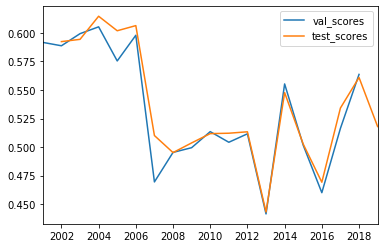

In [32]:
val_scores_series = pd.DataFrame({'val_scores':val_scores}, index = range(start_year + 1,2019))
test_scores_series = pd.DataFrame({'test_scores':test_scores}, index = range(start_year + 2, 2020))
scores_df = pd.concat([val_scores_series, test_scores_series], axis = 1)
scores_df.plot.line()

In [20]:
np.mean(test_scores)

0.535059620420125

### Feature Importance and Permutation Importance 

In [21]:
X_cols_subset_1 = ML_cols_subset_1.copy()
X_cols_subset_1.remove('player_1_win')
pd.Series(model.feature_importances_, index=X_cols_subset_1).sort_values(ascending=False)

player_old_elo_diff                     0.500091
player_win_weight_diff                  0.215907
player_game_win_ratio_diff              0.065439
player_rank_diff                        0.047956
player_log_rank_diff                    0.045237
player_return_win_ratio_diff            0.044913
player_point_win_ratio_weighted_diff    0.040568
player_serve_win_ratio_diff             0.039888
dtype: float32

In [22]:
perm = PermutationImportance(model).fit(X_2018, y_2018)
eli5.show_weights(perm, feature_names = X_2018.columns.tolist())

Weight,Feature
0.1535 ± 0.0536,player_old_elo_diff
0.0031 ± 0.0092,player_game_win_ratio_diff
0.0024 ± 0.0039,player_return_win_ratio_diff
0 ± 0.0000,player_point_win_ratio_weighted_diff
-0.0008 ± 0.0059,player_log_rank_diff
-0.0055 ± 0.0252,player_win_weight_diff
-0.0055 ± 0.0080,player_serve_win_ratio_diff
-0.0102 ± 0.0107,player_rank_diff


# Making ex-post predictions

In [23]:
#Creating our dummy submission file based on the AO draw
players = [
    'Rafael Nadal',
    'Hugo Dellien',
    'Federico Delbonis',
    'Joao Sousa',
    'Christopher Eubanks',
    'Peter Gojowczyk',
    'Jozef Kovalik',
    'Pablo Carreno Busta',
    'Nick Kyrgios',
    'Lorenzo Sonego',
    'Pablo Cuevas',
    'Gilles Simon',
    'Yasutaka Uchiyama',
    'Mikael Ymer',
    'Mario Vilella Martinez',
    'Karen Khachanov',
    'Gael Monfils',
    'Yen hsun Lu',
    'Ivo Karlovic',
    'Vasek Pospisil',
    'James Duckworth',
    'Aljaz Bedene',
    'Ernests Gulbis',
    'Felix Auger Aliassime',
    'Taylor Harry Fritz',
    'Tallon Griekspoor',
    'Ilya Ivashka',
    'Kevin Anderson',
    'Alex Bolt',
    'Albert Ramos',
    'Adrian Mannarino',
    'Dominic Thiem',
    'Daniil Medvedev',
    'Francis Tiafoe',
    'Dominik Koepfer',
    'Pedro Martinez',
    'Hugo Gaston',
    'Jaume Munar',
    'Alexei Popyrin',
    'Jo Wilfried Tsonga',
    'John Isner',
    'Thiago Monteiro',
    'Alejandro Tabilo',
    'Daniel Elahi Galan',
    'Miomir Kecmanovic',
    'Andreas Seppi',
    'Damir Dzumhur',
    'Stan Wawrinka',
    'David Goffin',
    'Jeremy Chardy',
    'Pierre Hugues Herbert',
    'Cameron Norrie',
    'Yuichi Sugita',
    'Elliot Benchetrit',
    "Christopher OConnell",
    'Andrey Rublev',
    'Nikoloz Basilashvili',
    'Soon woo Kwon',
    'Fernando Verdasco',
    'Evgeny Donskoy',
    'Casper Ruud',
    'Egor Gerasimov',
    'Marco Cecchinato',
    'Alexander Zverev',
    'Matteo Berrettini',
    'Andrew Harris',
    'Tennys Sandgren',
    'Marco Trungelliti',
    'Roberto Carballes Baena',
    'Ricardas Berankis',
    'Sam Querrey',
    'Borna Coric',
    'Guido Pella',
    'John Patrick Smith',
    'Mohamed Safwat',
    'Gregoire Barrere',
    'Jordan Thompson',
    'Alexander Bublik',
    'Reilly Opelka',
    'Fabio Fognini',
    'Denis Shapovalov',
    'Marton Fucsovics',
    'Jannik Sinner',
    'Max Purcell',
    'Leonardo Mayer',
    'Tommy Paul',
    'Juan Ignacio Londero',
    'Grigor Dimitrov',
    'Hubert Hurkacz',
    'Dennis Novak',
    'John Millman',
    'Ugo Humbert',
    'Quentin Halys',
    'Filip Krajinovic',
    'Steve Johnson',
    'Roger Federer',
    'Stefanos Tsitsipas',
    'Salvatore Caruso',
    'Philipp Kohlschreiber',
    'Marcos Giron',
    'Christian Garin',
    'Stefano Travaglia',
    'Lorenzo Giustino',
    'Milos Raonic',
    'Benoit Paire',
    'Cedrik Marcel Stebe',
    'Marin Cilic',
    'Corentin Moutet',
    'Pablo Andujar',
    'Michael Mmoh',
    'Feliciano Lopez',
    'Roberto Bautista Agut',
    'Diego Sebastian Schwartzman',
    'Lloyd George Muirhead Harris',
    'Alejandro Fokina',
    'Norbert Gombos',
    'Marc Polmans',
    'Mikhail Kukushkin',
    'Kyle Edmund',
    'Dusan Lajovic',
    'Daniel Evans',
    'Mackenzie Mcdonald',
    'Yoshihito Nishioka',
    'Laslo Djere',
    'Tatsuma Ito',
    'Prajnesh Gunneswaran',
    'Jan Lennard Struff',
    'Novak Djokovic'
]

player_permutations = list(itertools.permutations(players, 2))
dummy_submission_df = pd.DataFrame(player_permutations, columns=['player_1','player_2'])
dummy_submission_df.loc[:,'player_1_win_probability'] = 0.5
dummy_submission_df.to_csv('Data/dummy_submission_edited_2020.csv')

## Adding features to each player combination

In [24]:
df_predict_atp = dummy_submission_df
df_predict_atp['player_1'] = df_predict_atp['player_1'].str.lower() 
df_predict_atp['player_2'] = df_predict_atp['player_2'].str.lower()

rolling_features['player_name'] = rolling_features['player_name'].str.lower() 

#Adding tournament date to prediction df
df_predict_atp['tourney_start_date'] = pd.to_datetime('2020-01-20')


df_predict_atp = df_predict_atp.merge(rolling_features, how='left',
                                     left_on = ['player_1', 'tourney_start_date'],
                                     right_on = ['player_name', 'tournament_date_index'],
                                     validate = 'm:1')




In [25]:
rolling_features.columns

Index(['player_name', 'player_serve_win_ratio', 'player_return_win_ratio',
       'player_bp_per_game', 'player_bp_conversion_ratio',
       'player_game_win_ratio', 'player_point_win_ratio',
       'player_clutch_factor', 'player_win_weight',
       'player_game_win_ratio_weighted', 'player_point_win_ratio_weighted',
       'player_rank', 'player_log_rank', 'player_rank_points',
       'player_log_rank_points', 'player_ht', 'player_old_elo',
       'tournament_date_index'],
      dtype='object')

In [26]:
#Used to check for players who do not have rolling features to match or players whose names are spelt incorrectly
missing_names = df_predict_atp[df_predict_atp.isnull().any(axis=1)]['player_1'].unique()
missing_names.sort()
missing_names

array(['alejandro fokina', 'daniel elahi galan', 'pedro martinez',
       'yen hsun lu'], dtype=object)

In [27]:
all_players = deuce_atp_final.player_1.unique()
all_players.sort()
all_players

array(['Adam Pavlasek', 'Adrian Mannarino', 'Adrian Menendez Maceiras',
       'Adrian Ungur', 'Adrian Voinea', 'Agustin Calleri',
       'Aisam Ul Haq Qureshi', 'Alan Mackin', 'Albano Olivetti',
       'Albert Costa', 'Albert Montanes', 'Albert Portas', 'Albert Ramos',
       'Alberto Berasategui', 'Alberto Martin', 'Alejandro Falla',
       'Alejandro Gonzalez', 'Aleksandr Nedovyesov',
       'Alessandro Giannessi', 'Alessio Di Mauro', 'Alex Bogdanovic',
       'Alex Bogomolov Jr', 'Alex Bolt', 'Alex Calatrava',
       'Alex Corretja', 'Alex De Minaur', 'Alex Kim', 'Alex Kuznetsov',
       'Alex Lopez Moron', 'Alex Obrien', 'Alexander Bublik',
       'Alexander Kudryavtsev', 'Alexander Peya', 'Alexander Popp',
       'Alexander Sarkissian', 'Alexander Waske', 'Alexander Zverev',
       'Alexandr Dolgopolov', 'Alexandre Simoni', 'Alexei Popyrin',
       'Aljaz Bedene', 'Alun Jones', 'Amer Delic', 'Amir Weintraub',
       'Andre Agassi', 'Andre Sa', 'Andrea Gaudenzi', 'Andrea Stoppini'

In [28]:
df_predict_atp = df_predict_atp.merge(rolling_features, how='left',
                                     left_on = ['player_2', 'tourney_start_date'],
                                     right_on = ['player_name', 'tournament_date_index'],
                                     validate = 'm:1',
                                     suffixes = ('_p1','_p2'))


In [29]:
#Filling in missing values for players with no aggregates prior to 2020 AO
df_predict_atp.loc[:,'player_rank_p1'].fillna(500, inplace=True)
df_predict_atp.loc[:,'player_rank_p2'].fillna(500, inplace=True)
df_predict_atp.loc[:,'player_log_rank_p1'].fillna(np.log(500), inplace=True)
df_predict_atp.loc[:,'player_log_rank_p2'].fillna(np.log(500), inplace=True)
df_predict_atp.loc[:,['player_log_rank_p1','player_log_rank_p2']].fillna(np.log(500), inplace=True)
df_predict_atp.fillna(-1, inplace=True) ##### <- important

#These players with no previous match history are slightly suspect, good to check if we have filled in their values correctly
df_predict_atp[(df_predict_atp.player_1.isin(['alejandro fokina', 'andrew harris', 'christopher oconnell',
       'hugo gaston', 'james duckworth', 'john patrick smith',
       'michael mmoh', 'yen hsun lu']))]

,Unnamed: 0,player_1,player_2,player_1_win_probability,tourney_start_date,player_name_p1,player_serve_win_ratio_p1,player_return_win_ratio_p1,player_bp_per_game_p1,player_bp_conversion_ratio_p1,player_game_win_ratio_p1,player_point_win_ratio_p1,player_clutch_factor_p1,player_win_weight_p1,player_game_win_ratio_weighted_p1,player_point_win_ratio_weighted_p1,player_rank_p1,player_log_rank_p1,player_rank_points_p1,player_log_rank_points_p1,player_ht_p1,player_old_elo_p1,tournament_date_index_p1,player_name_p2,player_serve_win_ratio_p2,player_return_win_ratio_p2,player_bp_per_game_p2,player_bp_conversion_ratio_p2,player_game_win_ratio_p2,player_point_win_ratio_p2,player_clutch_factor_p2,player_win_weight_p2,player_game_win_ratio_weighted_p2,player_point_win_ratio_weighted_p2,player_rank_p2,player_log_rank_p2,player_rank_points_p2,player_log_rank_points_p2,player_ht_p2,player_old_elo_p2,tournament_date_index_p2
2159,2159,yen hsun lu,rafael nadal,0.5,2020-01-20,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,500.0,6.214608,-1.0,-1.0,-1.0,-1.0,-1,rafael nadal,0.701927,0.395480,0.639543,0.442393,0.622003,0.542192,0.070236,0.567970,0.567058,0.492981,2.0,0.693147,7945.0,8.980298,185.000000,2736.528396,2020-01-20 00:00:00
2160,2160,yen hsun lu,hugo dellien,0.5,2020-01-20,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,500.0,6.214608,-1.0,-1.0,-1.0,-1.0,-1,hugo dellien,0.580818,0.377711,0.623797,0.366715,0.530976,0.487694,0.043283,0.068890,0.372648,0.383517,84.0,4.430817,618.0,6.426488,185.042357,2172.020619,2020-01-20 00:00:00
2161,2161,yen hsun lu,federico delbonis,0.5,2020-01-20,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,500.0,6.214608,-1.0,-1.0,-1.0,-1.0,-1,federico delbonis,0.601685,0.358896,0.564886,0.525092,0.471781,0.480563,-0.008782,0.156573,0.484047,0.493144,67.0,4.204693,869.0,6.767343,190.000000,2238.795130,2020-01-20 00:00:00
2162,2162,yen hsun lu,joao sousa,0.5,2020-01-20,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,500.0,6.214608,-1.0,-1.0,-1.0,-1.0,-1,joao sousa,0.626402,0.337025,0.441870,0.329192,0.475559,0.484985,-0.009426,0.148395,0.440014,0.455121,43.0,3.761200,1061.0,6.966967,185.000000,2128.026680,2020-01-20 00:00:00
2163,2163,yen hsun lu,christopher eubanks,0.5,2020-01-20,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,500.0,6.214608,-1.0,-1.0,-1.0,-1.0,-1,christopher eubanks,0.674508,0.337458,0.461262,0.410166,0.506715,0.505611,0.001105,0.042914,0.455516,0.458638,193.0,5.262690,267.0,5.587249,185.042357,2077.332137,2020-01-20 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14600,14600,alejandro fokina,laslo djere,0.5,2020-01-20,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,500.0,6.214608,-1.0,-1.0,-1.0,-1.0,-1,laslo djere,0.555545,0.333069,0.398504,0.520089,0.390236,0.448281,-0.058045,0.051848,0.378729,0.436881,39.0,3.663562,1245.0,7.126891,185.042357,2217.102347,2020-01-20 00:00:00
14601,14601,alejandro fokina,tatsuma ito,0.5,2020-01-20,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,500.0,6.214608,-1.0,-1.0,-1.0,-1.0,-1,tatsuma ito,0.651605,0.403785,0.831916,0.371623,0.567402,0.523978,0.043424,0.054782,0.402794,0.381343,141.0,4.948760,401.0,5.993961,180.000000,2036.062530,2020-01-20 00:00:00
14602,14602,alejandro fokina,prajnesh gunneswaran,0.5,2020-01-20,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,500.0,6.214608,-1.0,-1.0,-1.0,-1.0,-1,prajnesh gunneswaran,0.670919,0.365199,0.576871,0.383220,0.535219,0.514290,0.017927,0.052260,0.379621,0.379610,89.0,4.488636,600.0,6.396930,185.042357,2121.835798,2020-01-20 00:00:00
14603,14603,alejandro fokina,jan lennard struff,0.5,2020-01-20,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,500.0,6.214608,-1.0,-1.0,-1.0,-1.0,-1,jan lennard struff,0.674155,0.337331,0.476576,0.317752,0.506278,0.502858,0.003420,0.287657,0.506298,0.503182,35.0,3.555348,1265.0,7.142827,185.042357,2354.738147,2020-01-

In [30]:
df_predict_atp = get_player_difference(df_predict_atp, diff_cols=diff_cols)

## Making predictions

In [31]:
ML_cols_subset_1.remove('player_1_win')
atp_preds = final_model.predict_proba(df_predict_atp[ML_cols_subset_1])
df_predict_atp['player_1_win_probability'] = atp_preds[:,1]

atp_pred_submission = df_predict_atp[['player_1', 'player_2', 'player_1_win_probability']]
atp_pred_submission.to_csv('Data/test_submission_expost.csv')
atp_pred_submission

,player_1,player_2,player_1_win_probability
0,rafael nadal,hugo dellien,0.908778
1,rafael nadal,federico delbonis,0.908778
2,rafael nadal,joao sousa,0.908778
3,rafael nadal,christopher eubanks,0.894185
4,rafael nadal,peter gojowczyk,0.908778
...,...,...,...
16251,novak djokovic,yoshihito nishioka,0.908778
16252,novak djokovic,laslo djere,0.903594
16253,novak djokovic,tatsuma ito,0.909225
16254,novak djokovic,prajnesh gunneswaran,0.908778


In [34]:
# Ranking players by average predicting win probability 
atp_pred_submission.groupby('player_1')['player_1_win_probability'].agg('mean').sort_values(ascending=False).head(100)

player_1
rafael nadal                    0.883121
novak djokovic                  0.879700
roger federer                   0.877201
dominic thiem                   0.826868
daniil medvedev                 0.780728
matteo berrettini               0.774844
kevin anderson                  0.759034
stefanos tsitsipas              0.754115
alexander zverev                0.748855
gael monfils                    0.741878
diego sebastian schwartzman     0.732697
stan wawrinka                   0.726816
john isner                      0.717387
roberto bautista agut           0.712696
david goffin                    0.711760
jo wilfried tsonga              0.708516
nick kyrgios                    0.707493
milos raonic                    0.689394
andrey rublev                   0.688020
felix auger aliassime           0.685827
grigor dimitrov                 0.684093
kyle edmund                     0.671568
marin cilic                     0.660699
denis shapovalov                0.656660
filip k